In [24]:
import pickle
from pathlib import Path

import joblib
import keras
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

from utils import *

In [2]:
pc = ProjectConfig()
MODEL_DIR = pc.project_root_dir.joinpath("src").joinpath("model_fine_tuned_saves")
MODEL_NAME = "efficientnet_v2m"
MODEL_PATH = MODEL_DIR.joinpath(MODEL_NAME + ".h5")
CLASS_LIST_PATH = pc.project_root_dir.joinpath("src").joinpath("class_list.lzma")
TEST_DATA = pc.data_root_dir.joinpath("sampled_test_data")

No configuration file found. Using defaults.


In [3]:
if CLASS_LIST_PATH.exists():
    classes = joblib.load(CLASS_LIST_PATH)
else:
    print("No class list found, please run the training script first")

In [4]:
if TEST_DATA.exists() and TEST_DATA.is_dir():
    print("Test data found, loading")
    test_data = tf.keras.utils.image_dataset_from_directory(
        TEST_DATA,
        labels="inferred",
        label_mode="int",
        batch_size=32,
        image_size=(224, 224),
        shuffle=False,
    )
else:
    print("No test data found, where did it go?")

Test data found, loading
Found 7000 files belonging to 70 classes.


2024-03-17 15:28:49.329550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 15:28:49.383045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 15:28:49.383401: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 15:28:49.384659: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 15:28:49.384961: I external/local_xla/xla/stream_executor

In [5]:
if MODEL_PATH.exists():
    model = tf.keras.models.load_model(MODEL_PATH)
    model.trainable = False
    print("Model loaded from disk")
else:
    print("Model not found at path:", MODEL_PATH)

Model loaded from disk


In [6]:
predictions = model.predict(test_data)

2024-03-17 15:29:15.036029: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


219/219 [==============================] - 26s 91ms/step


In [20]:
predicted_classes = np.argmax(predictions, axis=-1)

0

In [22]:
true_labels = []
for images, true_label in test_data:
    true_labels.extend(true_label)

In [26]:
all_predictions = np.array(predicted_classes)
all_true_labels = np.array(true_labels)
all_classes = np.array(classes)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

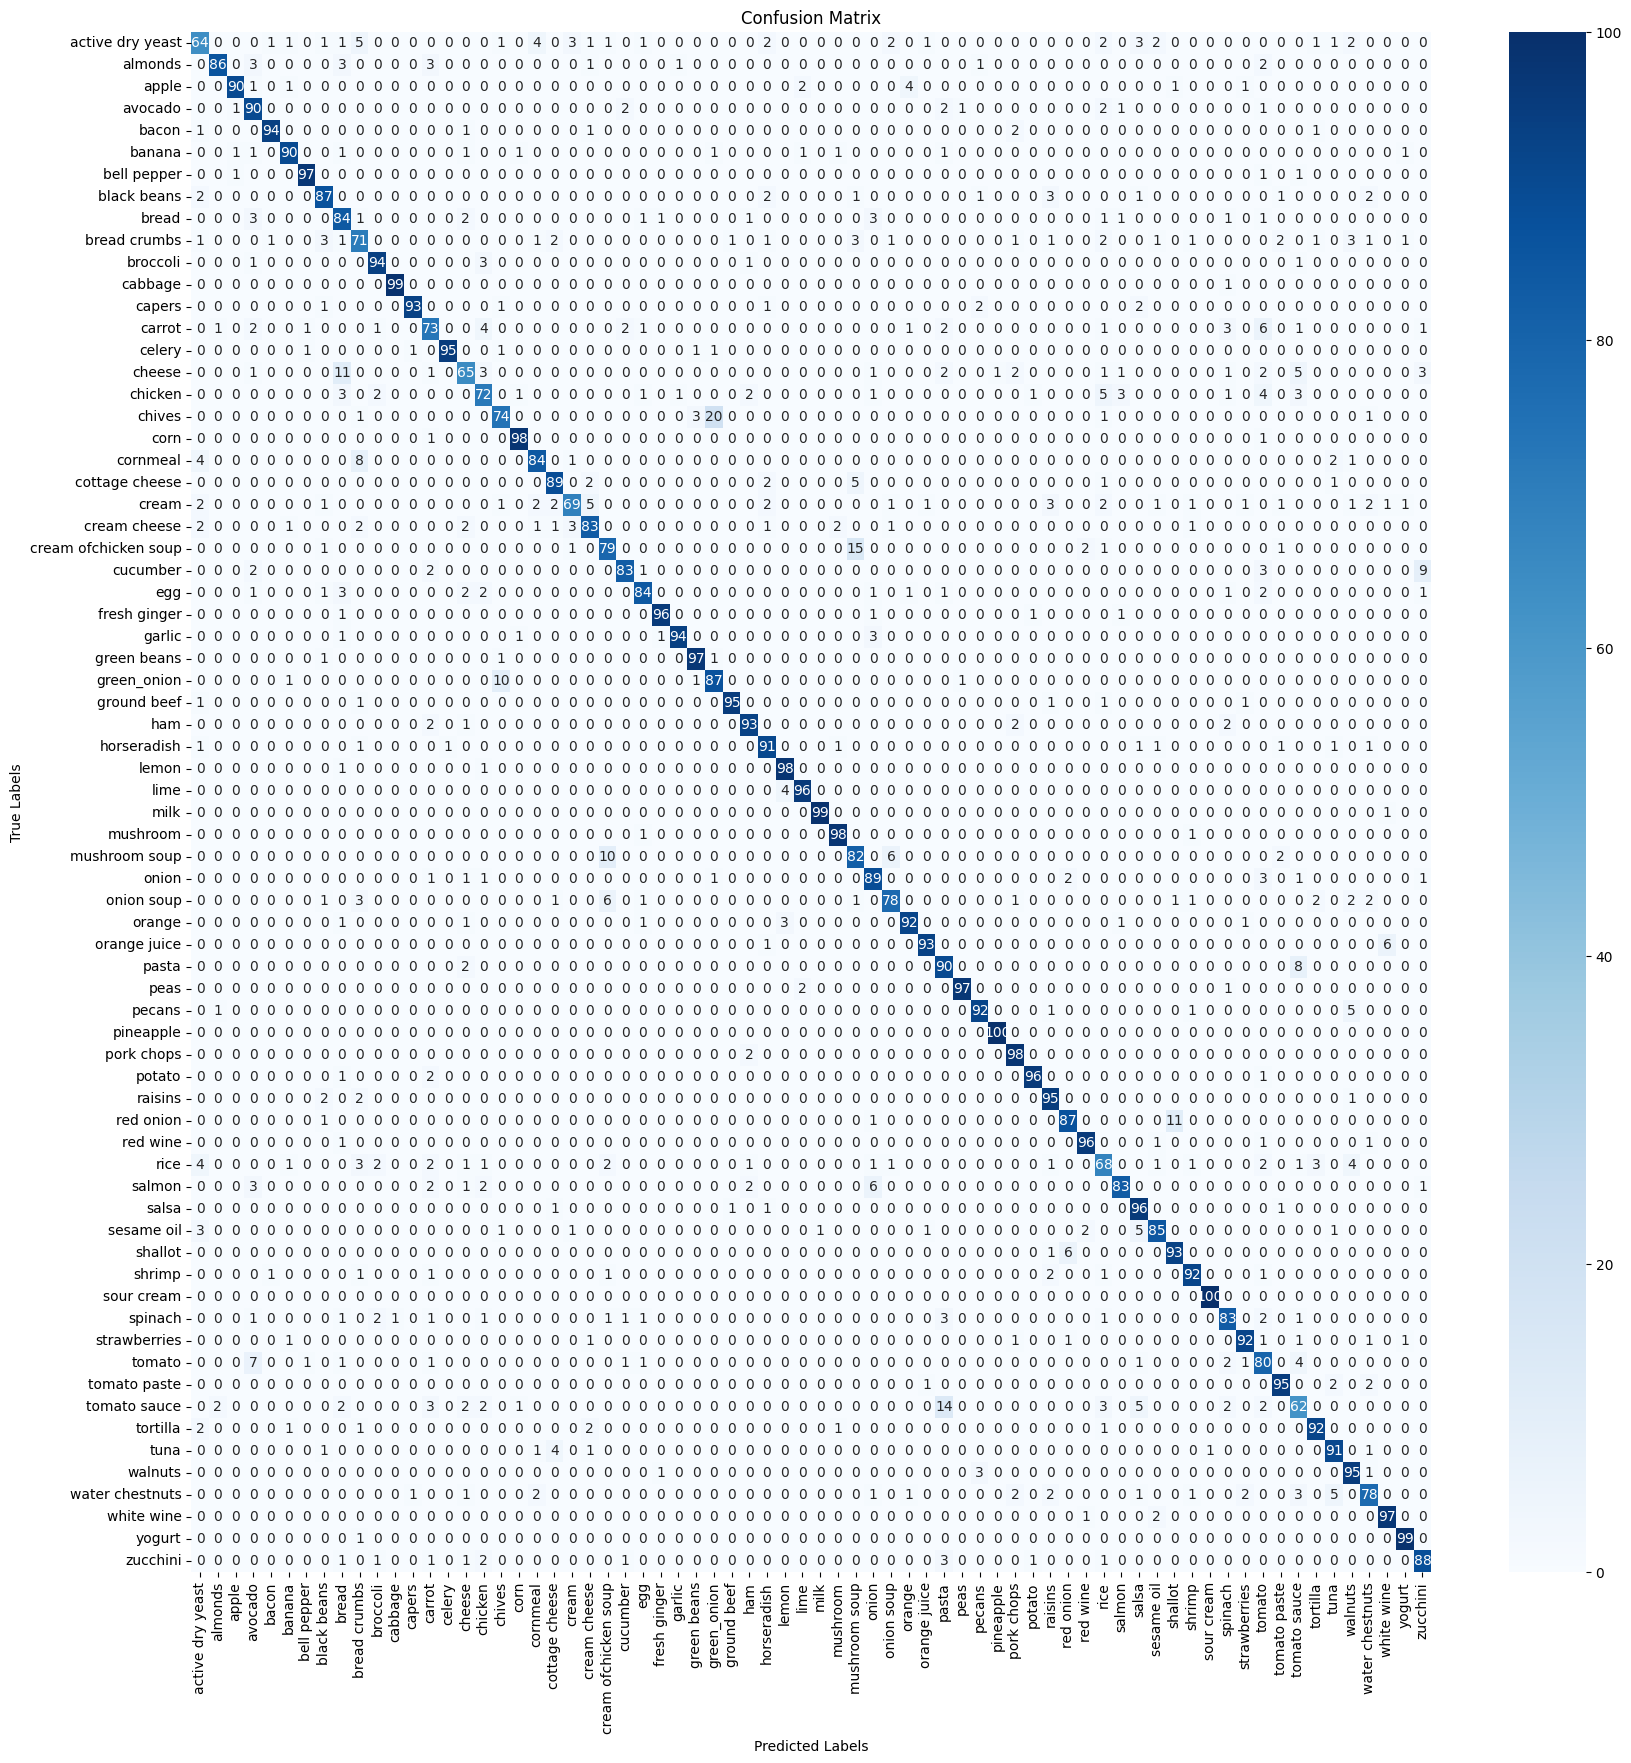

In [29]:
plt.figure(figsize=(20, 20))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=all_classes,
    yticklabels=all_classes,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()